# **Import necessary modules**

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import os

TensorFlow 2.x selected.


In [0]:
# Paths
root = '.'
data_path = os.path.join(root, 'data', 'icml_face_data.csv')

In [0]:
sys.path.append(root)
from model import Model

# **Define Constants**

In [0]:
# Training constants
# Prone to modifications
batch_size = 128*2
buffer_size = 10000
learning_rate = 1e-3

# **Choice of Loss Functions and Optimizers**

In [0]:
# Loss functions
catagorical_crossentropy_loss = tf.keras.losses.CategoricalCrossentropy()
kl_divergence_loss = tf.keras.losses.KLDivergence()

# Optimizers
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

# **Data Extraction and Conversion**

In [0]:
dataset = pd.read_csv(data_path)
train_data = dataset[dataset[' Usage'] == 'Training']
val_data = dataset[dataset[' Usage'] == 'PrivateTest']

In [0]:
def train_data_gen():
    for _, row in train_data.iterrows():
        emotion = int(row.emotion)
        onehot_emotion = np.eye(7)[emotion].T.reshape((7, 1))
        image = np.fromstring(row[' pixels'], dtype=np.float32, sep=' ').reshape((48, 48, 1)) / 255.
        yield (image, onehot_emotion)

In [0]:
def val_data_gen():
    for _, row in val_data.iterrows():
        emotion = int(row.emotion)
        onehot_emotion = np.eye(7)[emotion].T.reshape((7, 1))
        image = np.fromstring(row[' pixels'], dtype=np.float32, sep=' ').reshape((48, 48, 1)) / 255.
        yield (image, onehot_emotion)

In [0]:
train_dataset = tf.data.Dataset.from_generator(train_data_gen,
                                               (tf.float32, tf.int32),
                                               (tf.TensorShape([48, 48, 1]), tf.TensorShape([7, 1]))).shuffle(buffer_size).batch(batch_size)
val_dataset = tf.data.Dataset.from_generator(val_data_gen,
                                             (tf.float32, tf.int32),
                                             (tf.TensorShape([48, 48, 1]), tf.TensorShape([7, 1]))).batch(batch_size)

# **Model Init and Compilation**

In [0]:
model = Model().get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 256)       2560      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 256)       1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48, 48, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 128)       295040    
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 23, 23, 128)       0

In [0]:
model.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

# **Method to plot accuracy variation throughout training**

In [0]:
def plot_accuracy_summary(history):
    plt.title('Loss')
    plt.plot(history.history['categorical_accuracy'], label='train')
    plt.plot(history.history['val_categorical_accuracy'], label='test')
    plt.legend()
    plt.show()

# **Callbacks**

In [0]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(os.path.join(root, 'weights', 'best_weights.h5'),
                                      monitor='val_categorical_accuracy',
                                      verbose=1,
                                      save_best_only=True, mode='max')


reducelr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                                         factor=0.1,
                                                         patience=5,
                                                         min_delta=0.01,verbose=1)

callbacks_list = [checkpoint_callback, reducelr_callback]

# **Model Training**

In [0]:
history = model.fit(train_dataset,
                    epochs=40,
                    verbose=2,
                    validation_data=val_dataset,
                    callbacks=callbacks_list)

Epoch 1/40

Epoch 00001: val_categorical_accuracy improved from -inf to 0.30148, saving model to /content/drive/My Drive/Experimental Projects/Emotion Detection/weights/best_weights.h5
113/113 - 45s - loss: 1.6824 - categorical_accuracy: 0.3595 - val_loss: 1.8938 - val_categorical_accuracy: 0.3015
Epoch 2/40

Epoch 00002: val_categorical_accuracy improved from 0.30148 to 0.31708, saving model to /content/drive/My Drive/Experimental Projects/Emotion Detection/weights/best_weights.h5
113/113 - 37s - loss: 1.4453 - categorical_accuracy: 0.4482 - val_loss: 1.8245 - val_categorical_accuracy: 0.3171
Epoch 3/40

Epoch 00003: val_categorical_accuracy improved from 0.31708 to 0.38228, saving model to /content/drive/My Drive/Experimental Projects/Emotion Detection/weights/best_weights.h5
113/113 - 37s - loss: 1.3246 - categorical_accuracy: 0.4939 - val_loss: 1.6744 - val_categorical_accuracy: 0.3823
Epoch 4/40

Epoch 00004: val_categorical_accuracy improved from 0.38228 to 0.50293, saving model 

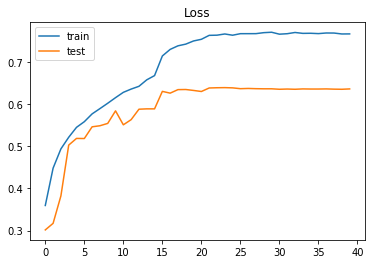

In [0]:
plot_accuracy_summary(history)